### Problema

O objetivo desse modelo é prever a precificação de imóveis para aluguel. Ao pensar em precificação, associamos a números, logo vamos resolver um problema de regressão. Além disso, trata-se de um modelo supervisionado, já que no dataset especificamos os dados de entrada e os dados de saída (o preço) e posteriormente, vamos incluir um novo dado e esperamos que ele retorne o preço do imóvel.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
df = pd.read_csv('../teste_indicium_precificacao.csv')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Renomeia as colunas para manter um padrão de idioma e melhorar a manipulação dos dados. Optei pelo inglês

In [4]:
df = df.rename(columns={'nome': 'name', 'bairro_group': 'neighborhood_group', 'bairro': 'neighborhood',
                        'minimo_noites': 'minimum_nights','numero_de_reviews': 'number_of_reviews',
                        'ultima_review': 'last_review', 'reviews_por_mes': 'reviews_per_month',
                        'calculado_host_listings_count': 'host_listing_count_calculated',
                        'disponibilidade_365': '365_days_availability'})

In [5]:
df['last_review'] = pd.to_datetime(df['last_review'])

Soma e define a porcentagem de nulos por cada coluna

In [6]:
sum_null_data = df.isnull().sum()
missing_data = sum_null_data.to_frame('sum').join((sum_null_data / df.shape[0] * 100).to_frame('percentage'))
missing_data # podemos ver que as features last_review e reviews_per_month tem muitos nulos

,sum,percentage
id,0,0.000000
name,16,0.032724
host_id,0,0.000000
host_name,21,0.042950
neighborhood_group,0,0.000000
neighborhood,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
room_type,0,0.000000
price,0,0.000000


Vamos gerar uma matriz de correlação para ver a correlação entre as features e o target (coluna price)

<Axes: title={'center': 'Matriz de Correlação'}>

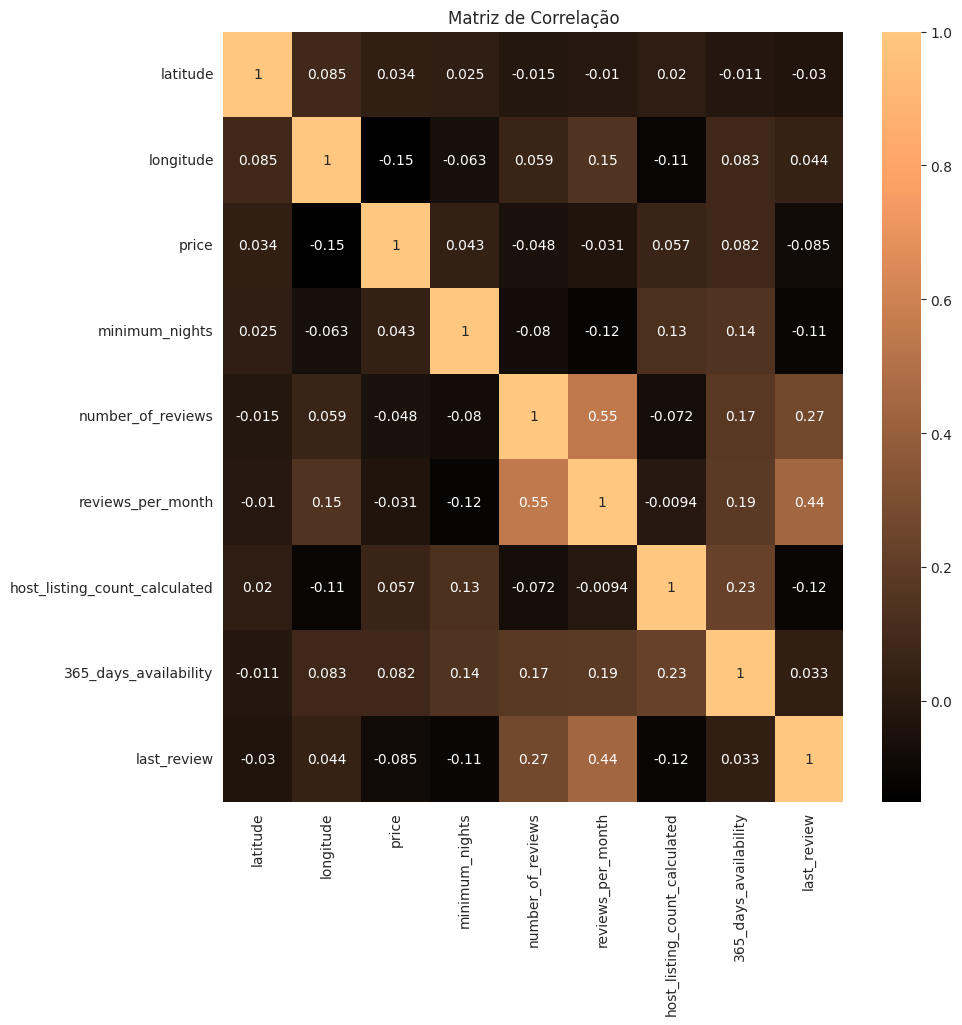

In [7]:
numeric_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                    'host_listing_count_calculated', '365_days_availability', 'last_review']

correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(10,10))
plt.title('Matriz de Correlação')

sns.heatmap(correlation_matrix, annot=True, cmap="copper")

Como vimos no gráfico anterior, muitas colunas possuem uma correlação negativa com a coluna price. E eu proponho diminuir as features e a necessidade de recursos computacionais maior. Nesse caso, vamos excluir as colunas que tem uma correlação negativa com a coluna target, pois como vimos no EDA, elas não interferem no preço.

In [8]:
df_filtered = df.drop(columns=['name', 'host_name', 'host_id', 'id', 'reviews_per_month', 'number_of_reviews', 'longitude', 'last_review'])

Como vimos na EDA, não existem valores duplicados no dataset

Aqui dividimos as features(X) e o target(y)

In [9]:
X = df_filtered.drop(columns='price')
y = df['price']

Dividindo em train e test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3)

### Pipelines para organização na manipulação de variáveis categóricas e numéricas

In [11]:
numeric_features = (X_train.dtypes == 'int') #como os dois dataset tem as mesmas colunas object, a variável vai servir pros dois
numeric_features = list(numeric_features[numeric_features].index)

categorical_features = (X_train.dtypes == 'object')
categorical_features = list(categorical_features[categorical_features].index)

Aqui, criei pipelines para os transformadores das variáveis numéricas e categóricas.

No 'imputer', para variáveis numéricas, escolhi substituir os valores nulos por 0, já que são variáveis discretas e a ausência de valores pode ser vista como 0. Para as variáveis categóricas, escolhi substituir pela moda, pois assim a distribuição original da variável é mantida.

Para as variáveis numéricas escolhi usar a padronização, pois ela é menos sensível a outliers e nosso dados têm uma quantidade considerável, como vimos anteriormente. Para a padronização escolhi o StandardScaler, ela transforma os dados para que eles tenham média 0 e desvio padrão 1.

Para variáveis categóricas escolhi usar o One-Hot Encoding, pois ele transforma cada categoria em uma coluna binária, onda cada coluna representa uma categoria distinta e é muito utilizado para variáveis nominais, o que é o nosso caso.

In [12]:
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
                                        ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'most_frequent')),
                                          ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('numerical', numerical_transformer, numeric_features),
                                 ('categorical', categorical_transformer, categorical_features)])

Aqui criei o Pipeline do modelo, passando o preprocessor, no qual os dados numéricos e categóricos serão transformados; e passando o modelo, eu escolhi o LinearRegression, pois ele é mais fácil de interpretar e é um modelo mais simples.

In [13]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])

Testando para os seguintes modelos

In [14]:
models = {'model': [DecisionTreeRegressor(), HistGradientBoostingRegressor(), GradientBoostingRegressor(), LinearRegression()]}

Usei o GridSearchCV para rodar todos os modelos de teste e futuramente comparar a partir da métrica MAE. Utilizei a MAE porque é bastante eficiente em contextos com outliers e temos uma quantidade boa de outliers.

In [15]:
grid_model = GridSearchCV(estimator = model_pipeline, param_grid = models, cv = 5, scoring ='neg_mean_absolute_error', n_jobs = -1)

In [16]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['minimum_nights',
                                                                          'host_listing_count_calculated',
                                                                          '365_days_availability']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighborhood_group',
                                                                          'neighborhood',
                                                                          'room_type'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeRegressor(),
                                   HistGradientBoostingRegressor(),
                                   GradientBoostingRegressor(),
                                   LinearRegression()]},
             scoring='neg_mean_absolute_error')

In [17]:
df_cv_results = pd.DataFrame(grid_model.cv_results_)
df_cv_results[['rank_test_score', 'param_model', 'mean_test_score']]

,rank_test_score,param_model,mean_test_score
0,4,DecisionTreeRegressor(),-81.114468
1,1,HistGradientBoostingRegressor(),-69.707285
2,2,GradientBoostingRegressor(),-70.624903
3,3,LinearRegression(),-73.422157


Como vimos, o modelo que melhor saiu bem foi o HistGradientBoostingRegressor. Agora vamos testar o modelo de predição com ele e fazer os testes.

In [18]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', HistGradientBoostingRegressor())])

In [19]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['minimum_nights',
                                                   'host_listing_count_calculated',
                                                   '365_days_availability']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['neighborhood_group',
                                                   'neighborhood',
                                                   'room_type'])])),
                ('model', HistGradientBoostingRegressor())])

In [44]:
y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}\n'
      f'MSE: {mse}\n'
      f'RMSE: {rmse}\n'
      f'R2: {r2}')

MAE: 65.69873125018648
MSE: 45264.06568541158
RMSE: 212.75353272134302
R2: 0.12741565217431117


Precificando novo imóvel

{'id': 2595,

 'nome': 'Skylit Midtown Castle',

 'host_id': 2845,

 'host_name': 'Jennifer',

 'bairro_group': 'Manhattan',

 'bairro': 'Midtown',

 'latitude': 40.75362,

 'longitude': -73.98377,

 'room_type': 'Entire home/apt',

 'minimo_noites': 1,

 'numero_de_reviews': 45,

 'ultima_review': '2019-05-21',

 'reviews_por_mes': 0.38,

 'calculado_host_listings_count': 2,

 'disponibilidade_365': 355}

In [48]:
new_data = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

new_df = pd.DataFrame([new_data])
new_df = new_df.rename(columns={'nome': 'name', 'bairro_group': 'neighborhood_group', 'bairro': 'neighborhood',
                        'minimo_noites': 'minimum_nights','numero_de_reviews': 'number_of_reviews',
                        'ultima_review': 'last_review', 'reviews_por_mes': 'reviews_per_month',
                        'calculado_host_listings_count': 'host_listing_count_calculated',
                        'disponibilidade_365': '365_days_availability'})
new_df

,id,name,host_id,host_name,neighborhood_group,neighborhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,host_listing_count_calculated,365_days_availability
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355


In [49]:
y_pred = model_pipeline.predict(new_df)
y_pred

array([377.37938115])

In [53]:
joblib.dump(model_pipeline, 'model_pipeline.pkl')

['model/model_pipeline.pkl']